In [1]:
# import packages
import os
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False 

In [7]:
directory = os.getcwd()
filename = "transformed_sorted_file.csv"
file_path = os.path.join(directory, filename)

# data_raw=pd.read_excel(file_path,header=None)
df_raw=pd.read_csv(file_path)

In [12]:
# Perform forward fill to fill NaN values
df_filled = df_raw.fillna(method='ffill')
# Remove rows with NaN values after forward fill
df_cleaned = df_filled.dropna()
df_cleaned['TS'] = pd.to_datetime(df_cleaned['TS'])

In [25]:
# 定义正常生产
def is_producing(row):
    #if row['挤压机出口胶温度'] >= 40 and row['入口胶温度'] >= 32 and row['Cross Scoring Rollers 横刀速度'] > 100:
    if row['CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'] >= 40 and row['CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumEntranceTemperature'] >= 32 and row['CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rActualVelocityRPM'] > 100:
        return 1 # 在生产
    else:
        return 0 # 在停机

# 应用筛选条件，新增'是否生产中'列
df_cleaned['producing'] = df_cleaned.apply(is_producing, axis=1)
# 创建 switch_on 列，标记从停机到生产的转变
df_cleaned['switch_on'] = (df_cleaned['producing'] == 1) & (df_cleaned['producing'].shift(1) == 0)
# 创建 start_time 列，记录每次生产开始的时刻
df_cleaned['start_time'] = df_cleaned['TS'].where(df_cleaned['switch_on']).ffill()
df_cleaned['end_time'] = df_cleaned['TS'].where(df_cleaned['switch_on'].shift(-1)).bfill()
# 计算生产时间（prod_time），单位为分钟
df_cleaned['prod_time'] = (df_cleaned['TS'] - df_cleaned['start_time']).dt.total_seconds() / 60

In [26]:
df_cleaned.head()

,TS,CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1InletTemp,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1OutletTemp,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2InletTemp,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2OutletTemp,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumEntranceTemperature,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumExitTempLeft,CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumExitTempRight,...,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_LB_Temp_SP,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_PH_Temp_RealValue,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_PH_Temp_SP,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_UB_Temp_RealValue,SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_UB_Temp_SP,producing,switch_on,start_time,prod_time,end_time
1,2024-08-22 19:43:45,47.731480,-14.0,-14.050926,-12.138310,-14.571758,-12.774883,38.874420,24.638310,24.508102,...,40.0,49.67,50.0,40.33,40.0,1,False,NaT,NaN,2024-08-23 00:01:20
2,2024-08-22 19:43:46,47.534720,-14.0,-14.050926,-12.138310,-14.571758,-12.774883,38.686344,24.696180,24.703415,...,40.0,49.56,50.0,40.33,40.0,1,False,NaT,NaN,2024-08-23 00:01:20
3,2024-08-22 19:43:47,47.534720,-14.0,-14.050926,-12.152779,-14.571758,-12.774883,38.780384,25.788483,24.088543,...,40.0,49.67,50.0,40.33,40.0,1,False,NaT,NaN,2024-08-23 00:01:20
4,2024-08-22 19:43:48,47.650460,-14.0,-14.050926,-12.138310,-14.571758,-12.774883,38.874420,24.992765,24.117477,...,40.0,49.56,50.0,40.33,40.0,1,False,NaT,NaN,2024-08-23 00:01:20
5,2024-08-22 19:43:49,47.569447,-14.0,-14.050926,-12.138310,-14.571758,-12.774883,38.686344,24.515335,24.544270,...,40.0,49.56,50.0,40.44,40.0,1,False,NaT,NaN,2024-08-23 00:01:20


In [27]:
df_cleaned.to_csv('cleaned_data.csv')

In [19]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636800 entries, 1 to 636800
Data columns (total 25 columns):
 #   Column                                                                            Non-Null Count   Dtype         
---  ------                                                                            --------------   -----         
 0   TS                                                                                636800 non-null  datetime64[ns]
 1   CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp                         636800 non-null  float64       
 2   CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint                  636800 non-null  float64       
 3   CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1InletTemp                   636800 non-null  float64       
 4   CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1OutletTemp                  636800 non-null  float64       
 5   CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2In

#### Compare SwitchOn with Producing

In [28]:
df_cleaned['label'] = np.where(df_cleaned['prod_time'] < 30, '开机半小时内', '生产半小时以上')

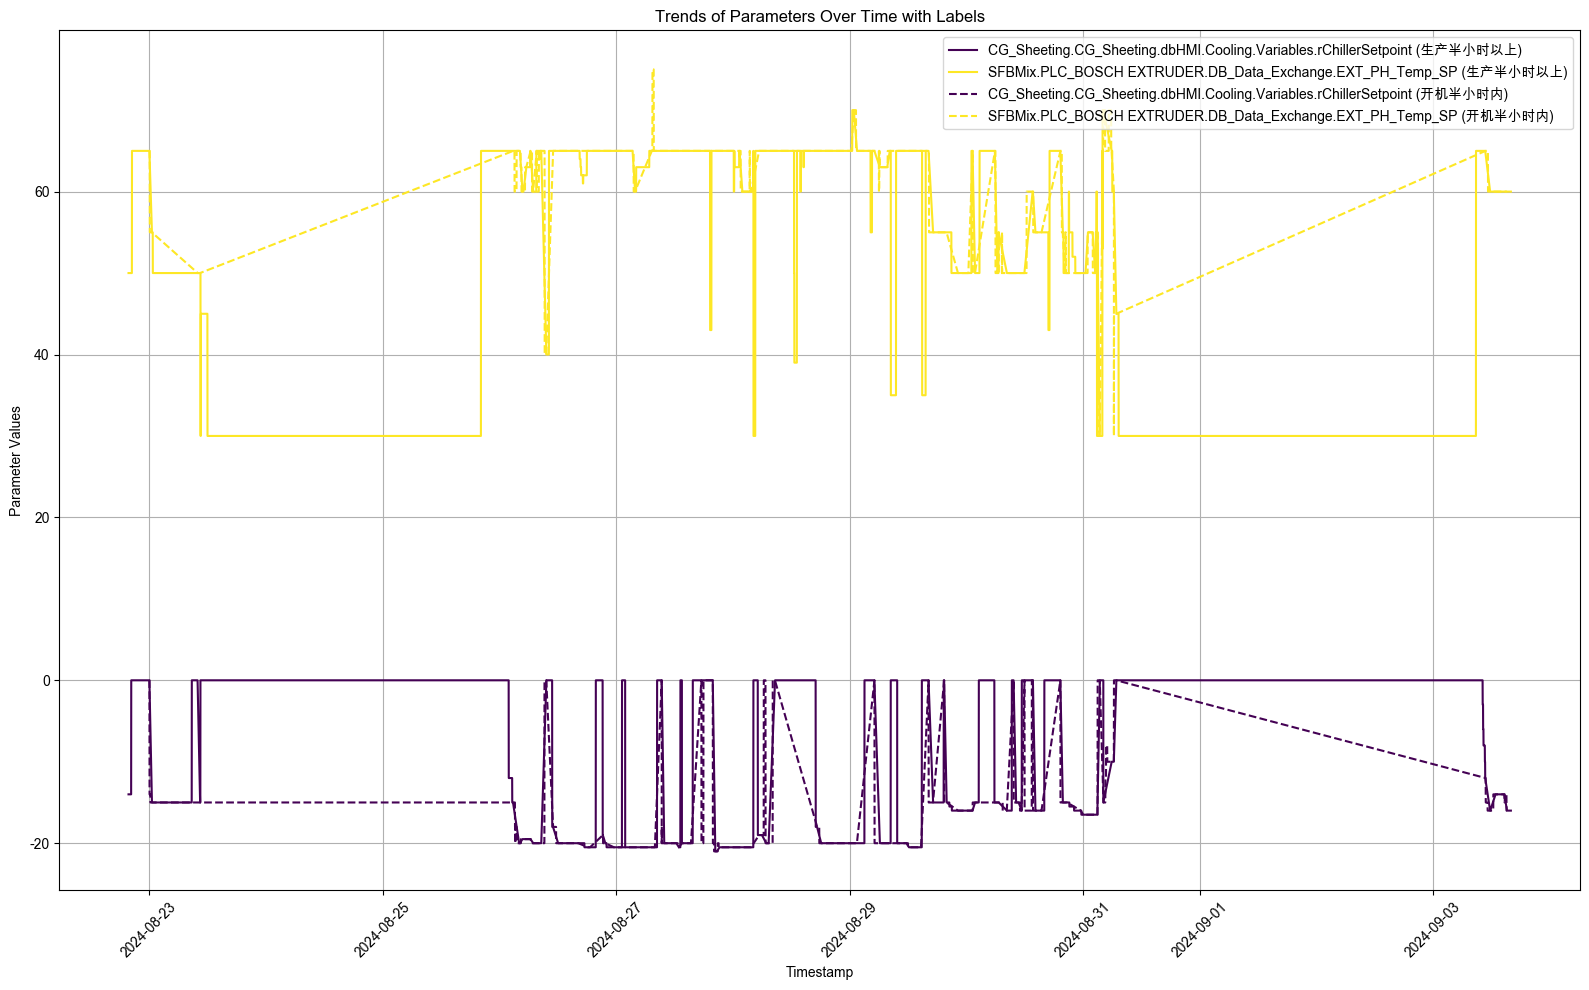

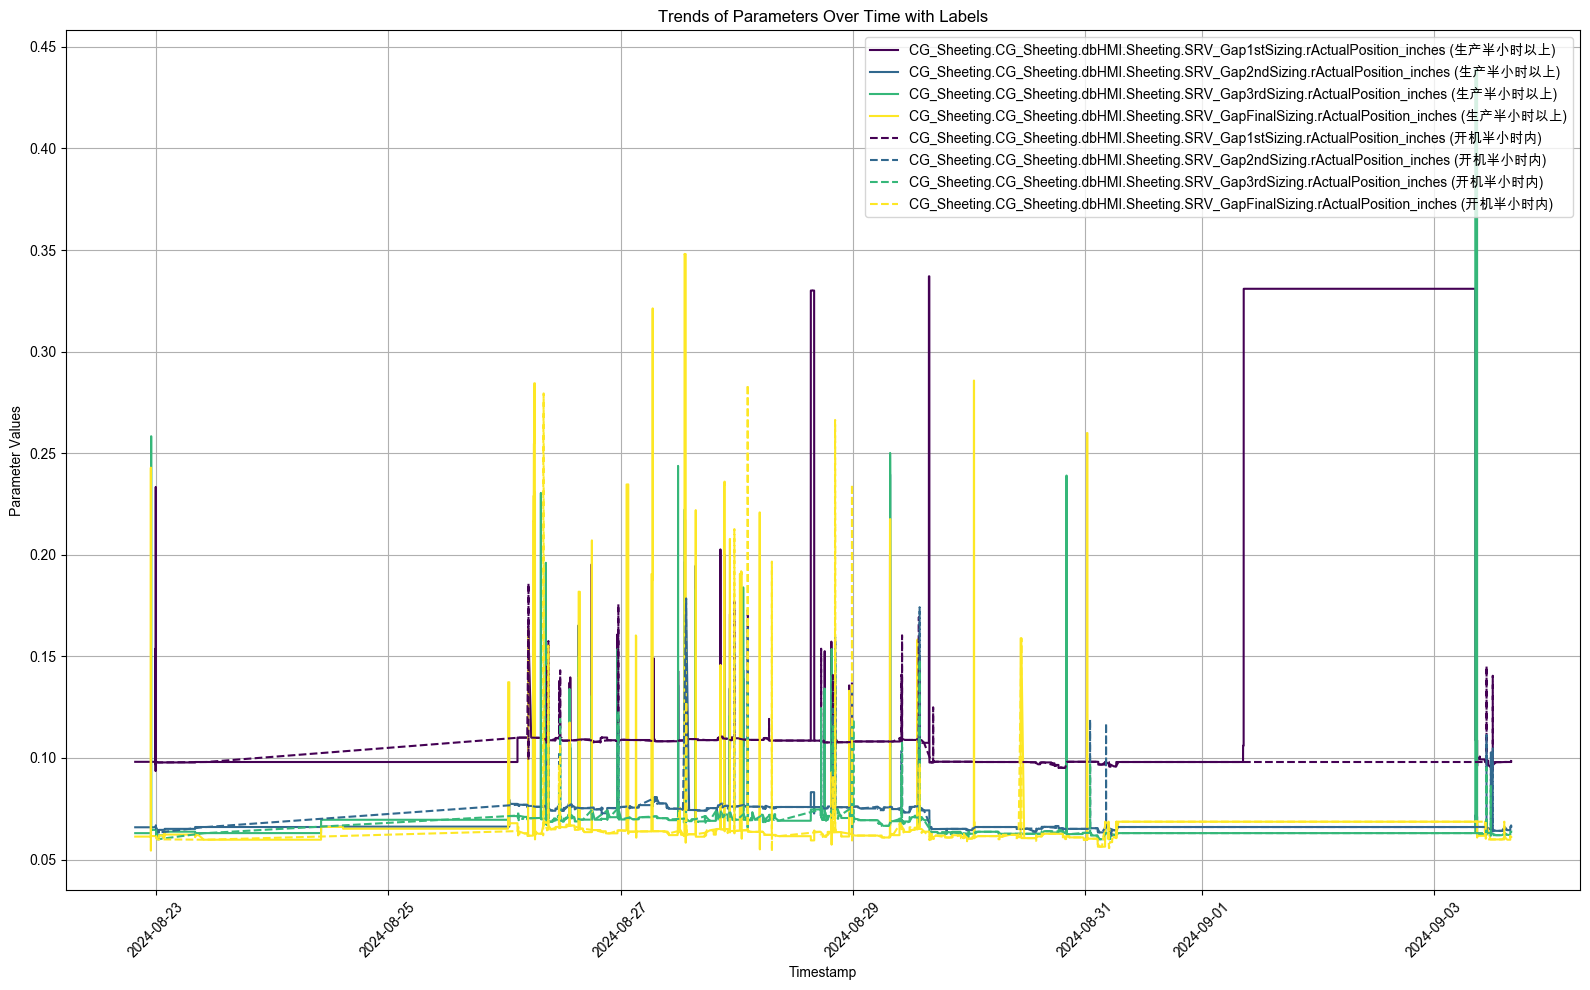

In [47]:
def plot_parameter_trends_with_labels(para_list, df, df_time_column='TS', label_column='label'):

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(16, 10))
    colors = plt.cm.viridis(np.linspace(0, 1, len(para_list)))

    # Plot each parameter for each label
    for i, label in enumerate(df[label_column].unique()):
        label_df = df[df[label_column] == label]
        for j, para in enumerate(para_list):
            # Use a different line style for each label
            linestyle = ['-', '--', '-.', ':', '.'][i % 5]  # 5 different line styles
            ax.plot(label_df[df_time_column], label_df[para], label=f"{para} ({label})", color = colors[j], linestyle=linestyle) # color=colors[i*len(para_list)+j]

    # Formatting the plot
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Trends of Parameters Over Time with Labels')
    legend_loc = 'upper right'
    ax.legend(loc=legend_loc)
    ax.grid(True)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

para_list_temperature = [
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint',
       'SFBMix.PLC_BOSCH EXTRUDER.DB_Data_Exchange.EXT_PH_Temp_SP'
]
plot_parameter_trends_with_labels(para_list_temperature, df_cleaned, df_time_column='TS', label_column='label')

para_list_roller = [
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSizing.rActualPosition_inches',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_GapFinalSizing.rActualPosition_inches'
]
plot_parameter_trends_with_labels(para_list_roller, df_cleaned, df_time_column='TS', label_column='label')

In [29]:
df_cleaned.columns

Index(['TS', 'CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rChillerSetpoint',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1InletTemp',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum1OutletTemp',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2InletTemp',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rDrum2OutletTemp',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumEntranceTemperature',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumExitTempLeft',
       'CG_Sheeting.CG_Sheeting.dbHMI.Cooling.Variables.rGumExitTempRight',
       'CG_Sheeting.CG_Sheeting.dbHMI.Scoring.SRV_CrossScore.rActualVelocityRPM',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap1stSizing.rActualPosition_inches',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap2ndSizing.rActualPosition_inches',
       'CG_Sheeting.CG_Sheeting.dbHMI.Sheeting.SRV_Gap3rdSiz

#### Visualisation

In [146]:
def plot_var_trend(df_raw, ts_name, var, lb, ub, var2, var2_threshold, start_ts, end_ts):
    # Check if var and var2 are numeric columns
    if not (pd.api.types.is_numeric_dtype(df_raw[var]) and pd.api.types.is_numeric_dtype(df_raw[var2])):
        raise ValueError("var and var2 must be numeric columns")
    
    df_raw[ts_name] = pd.to_datetime(df_raw[ts_name])
    df_filtered = df_raw[
                    (df_raw[var] < ub) & 
                     (df_raw[var] > lb) & 
                     (df_raw[ts_name] > start_ts) & 
                     (df_raw[ts_name] < end_ts)
                     ]
    
    df_filtered = df_filtered.set_index(ts_name)
    df_filtered = df_filtered[[var, var2]]
    
    # Create a new column to indicate whether the condition is met
    df_filtered['switch_on'] = np.where((df_filtered[var2] > var2_threshold) & 
                                        (df_filtered[var2].shift(5) < var2_threshold), 
                                        1, 0)
    
    df_filtered['switch_off'] = np.where((df_filtered[var2] < var2_threshold) & 
                                        (df_filtered[var2].shift(5) > var2_threshold), 
                                        1, 0)
    
    # Find the timestamps where the condition is met
    switch_on_timestamps = df_filtered[df_filtered['switch_on'] == 1].index
    switch_off_timestamps = df_filtered[df_filtered['switch_off'] == 1].index
    
    plt.figure(figsize=(20, 8))
    plt.plot(df_filtered[var])
    plt.title(f'Trend of {var} + {var2}开停记录')
    plt.xlabel(f'Timestamp ({start_ts} - {end_ts})')
    plt.ylabel(var)
    
    # # Add vertical lines at the highlight timestamps
    # for timestamp in switch_on_timestamps:
    #     plt.axvline(x=timestamp, color='red', linestyle='--')
    #     idx = df_filtered.index.get_loc(timestamp)
    #     plt.annotate('开', xy=(timestamp, df_filtered[var].iloc[idx]), xytext=(5, 0), 
    #                  textcoords='offset points', ha='center', va='center', 
    #                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    # for timestamp in switch_off_timestamps:
    #     plt.axvline(x=timestamp, color='blue', linestyle='--')
    #     idx = df_filtered.index.get_loc(timestamp)
    #     plt.annotate('停', xy=(timestamp, df_filtered[var].iloc[idx]), xytext=(5, 0), 
    #                  textcoords='offset points', ha='center', va='center', 
    #                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    # start_date = df_filtered.index.min().strftime('%Y%m%d')
    # end_date = df_filtered.index.max().strftime('%Y%m%d')
    # if start_date != end_date: 
    #     plt.savefig(f'{start_date}-{end_date}_{var}.png') 
    # else: 
    #     plt.savefig(f'{start_date}_{var}.png')
    
    return plt, df_filtered

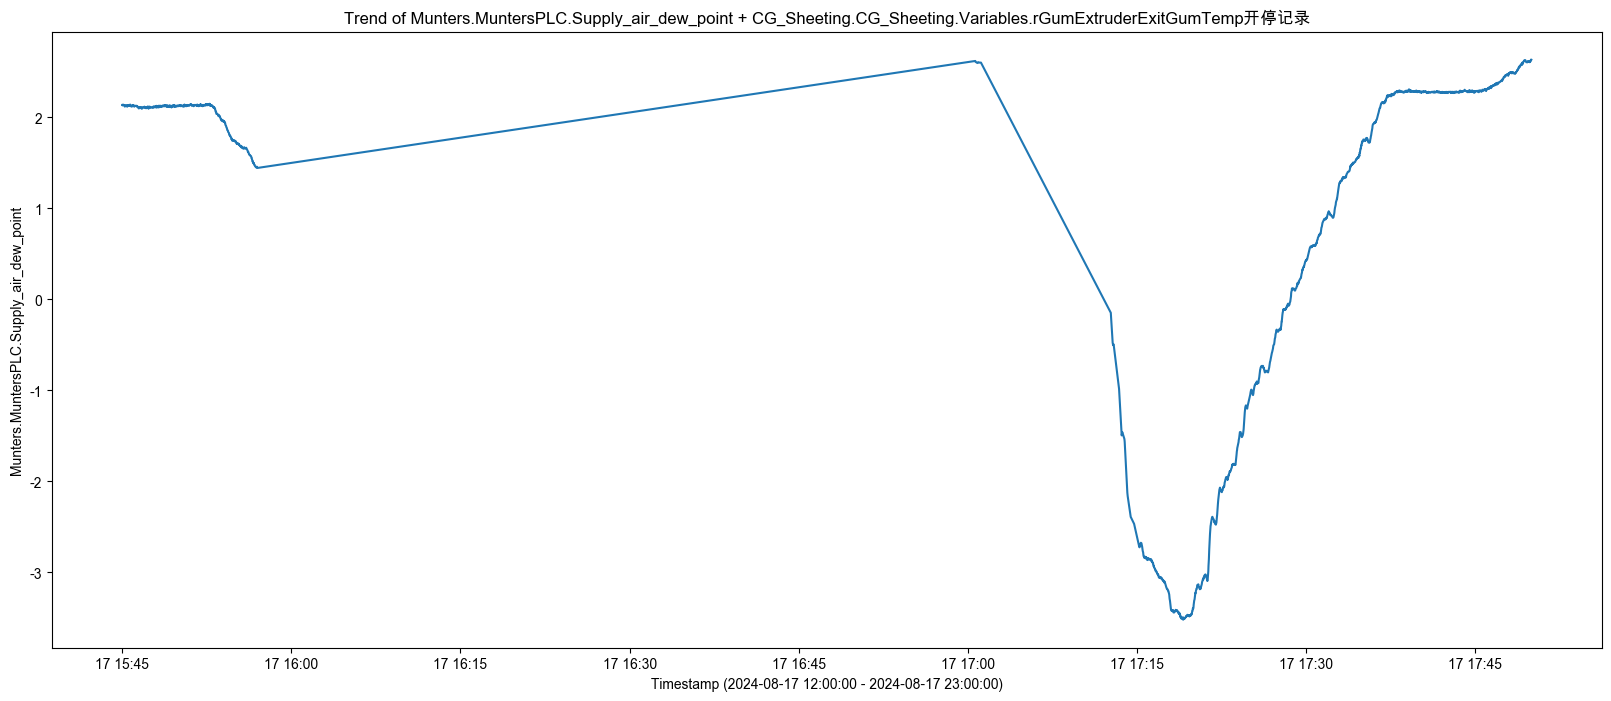

In [147]:
var = 'Munters.MuntersPLC.Supply_air_dew_point'
lb = -300
ub = 300
off_boundary = 50
on_boundary = 30
var2 = 'CG_Sheeting.CG_Sheeting.Variables.rGumExtruderExitGumTemp'
var2_threshold = 30
start_ts = '2024-08-17 12:00:00'
end_ts = '2024-08-17 23:00:00'

plot, df_filtered = plot_var_trend(df_merged_no_na, 'TS', var, lb, ub, var2, var2_threshold, start_ts, end_ts)

In [115]:
# export to excel
df_filtered.to_excel(f'{var}_with_{var2}开停记录.xlsx', index=True)

##### Idle Time

In [45]:
def calculate_idle_time(df_filtered, var, off_boundary, on_boundary, rounding_digit=0):
    # Calculate the rolling average of 10 samples
    rolling_avg = df_filtered[var].rolling(10).mean()

    # Find the first occurrence of the rolling average crossing a and b
    cond1 = round(rolling_avg, rounding_digit) == off_boundary
    cond2 = round(rolling_avg, rounding_digit) == on_boundary

    off_ts = cond1.idxmax() if cond1.any() else None
    on_ts = cond2.idxmax() if cond2.any() else None

    if off_ts is None or on_ts is None:
        raise ValueError("Idle time cannot be calculated")
    else:
        # Calculate the idle time
        idle_time = (on_ts - off_ts).total_seconds()  # Convert timedelta to seconds
        return idle_time, off_ts, on_ts

def convert_seconds_to_hhmmss(idle_time_seconds):
    hours, remainder = divmod(idle_time_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"


idle_time, off_ts, on_ts = calculate_idle_time(df_filtered, var, off_boundary, on_boundary, rounding_digit=0)
if not np.isnan(idle_time):
    idle_time_str = convert_seconds_to_hhmmss(idle_time)
    print(f'{var}的空载时间为:{idle_time_str} as hh:mm:ss. \n{off_ts}开始空载，{on_ts}开始生产')
else:
    print(f'{var}的空载时间无法计算.')

1号冷辊出口温度的空载时间为:03:24:58 as hh:mm:ss. 
2024-05-19 14:41:41开始空载，2024-05-19 18:06:39开始生产


In [4]:
# 缺失值处理
df_nona = df_raw.dropna(subset=['1号冷辊出口压力', '1号冷辊入口压力'])
print(df_nona.isna().sum())
df_plc = df_nona.fillna('ffill')

timestamp                          0
1号冷辊入口压力                           0
1号冷辊入口温度                           1
1号冷辊出口压力                           0
1号冷辊出口温度                           3
1号冷辊皮带速度                          11
1号辊轮速度                            59
1号辊间隙                             42
2号冷辊入口压力                           3
2号冷辊入口温度                           5
2号冷辊出口压力                           5
2号冷辊出口温度                           7
2号冷辊皮带速度                          23
2号辊轮速度                            57
2号辊间隙                             38
3号辊轮速度                            54
3号辊间隙                             34
Circular Scoring Rollers 圆刀速度     18
Cooling Roller 辊轮速度               49
Cross Scoring Rollers 横刀速度         1
Forming Roller 定型辊间隙              29
Forming Roller 辊轮速度               45
入口胶温度                              6
出口胶温度L                             7
出口胶温度R                            10
大辊速度                              50
大辊间隙                              30
挤

#### Correlation Plots

In [630]:
def lineplot_time_series_sample(df_sample,column='Extruder_gum_temp'):
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()
    plt.title('Correlation between weight and '+column)
    ax1.plot(df_sample['update_time'], df_sample[column], 'green')
    ax2.plot(df_sample['update_time'], df_sample['重量'], 'red')
    plt.show()
    
    #plt.figure(figsize=(5, 5))
    

In [633]:
weight_data=weight_data.replace(0,np.nan)

In [634]:
corr_columns=iot_columns+['重量']
corr_columns=[x for x in corr_columns if x !='挤压机螺杆转速']
corr_columns=[x for x in corr_columns if x !='1号冷辊皮带速度']
corr_columns=[x for x in corr_columns if x !='入口胶温度']

In [643]:
eng_weight_data[eng_corr_columns].corr()['weight'].sort_values()

Sheeting.SRV_GapBullRoll.rActualPosition_inches      -0.137954
Sheeting.SRV_GapFinalSizing.rActualPosition_inches   -0.108495
Sheeting.SRV_Gap1stSizing.rActualPosition_inches     -0.097263
Sheeting.SRV_Gap2ndSizing.rActualPosition_inches     -0.097080
rDrum1OutletTemp                                     -0.084350
rDrum2OutletTemp                                     -0.083911
rDrum1InletTemp                                      -0.082260
Bosch.TNK_BoschLevel.Status.rLevel                   -0.081136
rDrum2InletTemp                                      -0.049169
Cooling.SRV_ChillDrum1.rActualVelocityRPM            -0.032756
Scoring.SRV_CircularScore.rActualVelocityRPM         -0.031566
rDrum2OutletPressure                                 -0.027469
rDrum1InletPressure                                  -0.027085
rDrum2InletPressure                                  -0.024811
rDrum1OutletPressure                                 -0.023929
Proform.VFD_Lower_PowderBelt.rACTUAL_SPEED           -0

<AxesSubplot:>

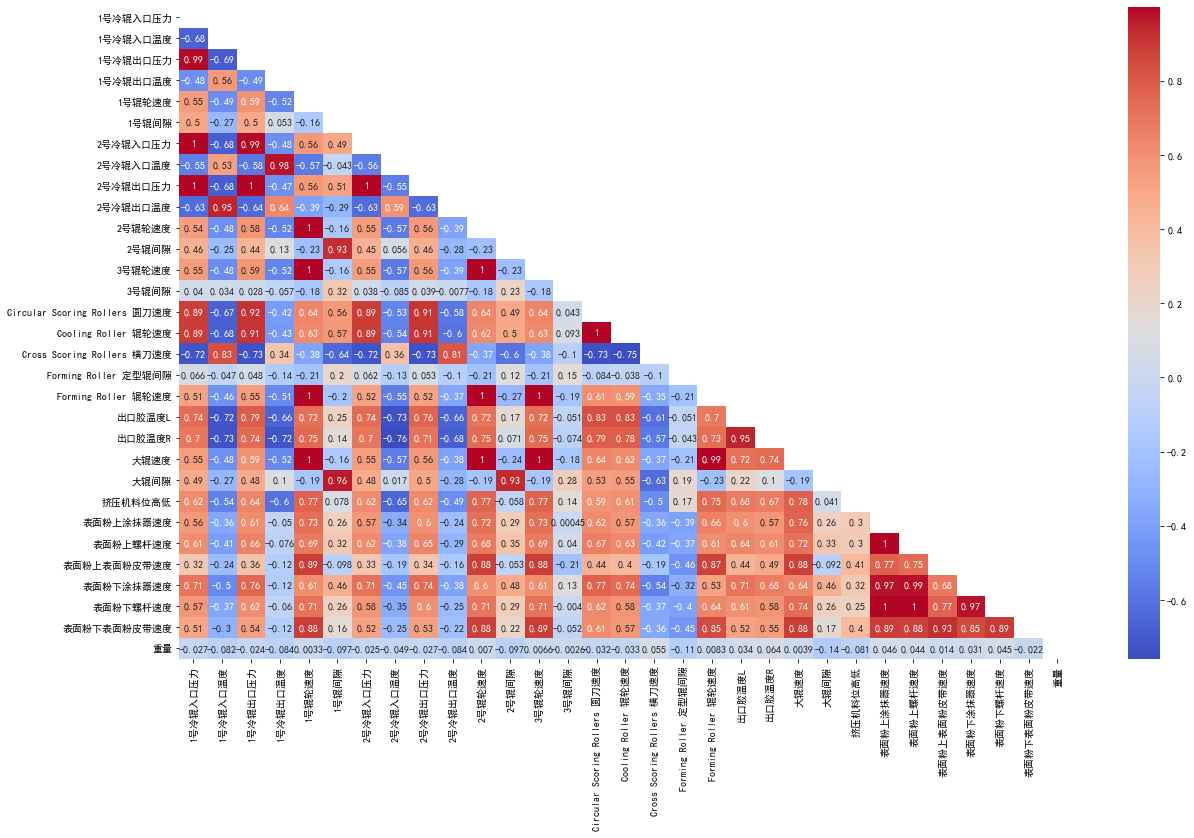

In [644]:
plt.rcParams['font.sans-serif'] = ['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False 
plt.subplots(figsize=(20,12))
mask = np.triu(np.ones_like(weight_data[corr_columns].corr()))
sns.heatmap(weight_data[corr_columns].corr(),cmap='coolwarm',annot=True, mask=mask)

<AxesSubplot:>

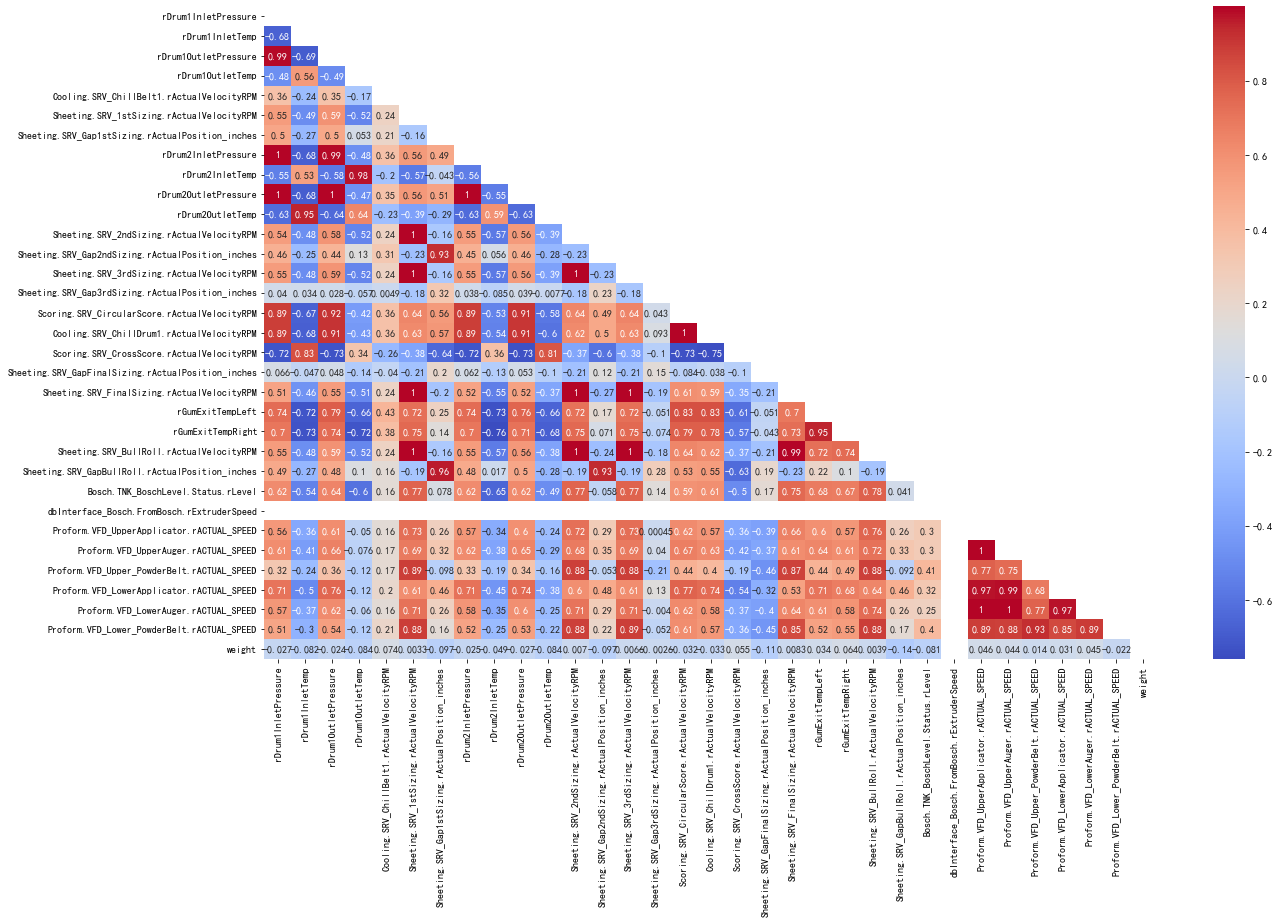

In [645]:
plt.rcParams['font.sans-serif'] = ['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False 
plt.subplots(figsize=(20,12))
mask = np.triu(np.ones_like(eng_weight_data[eng_corr_columns].corr()))
sns.heatmap(eng_weight_data[eng_corr_columns].corr(),cmap='coolwarm',annot=True, mask=mask)